# Twitch Recommender Systems - Initial EDA


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset

Loading the smaller `100k_a.csv` subset for quick EDA.  

- `user_id` (anonymized)
- `stream_id`
- `streamer_username`
- `time_start`
- `time_stop`


In [2]:
path_100k = "data/100k_a.csv"
df = pd.read_csv(path_100k, header=None)
df.columns = ["user_id", "stream_id", "streamer_username", "time_start", "time_stop"]

df.head()

,user_id,stream_id,streamer_username,time_start,time_stop
0,1,33842865744,mithrain,154,156
1,1,33846768288,alptv,166,169
2,1,33886469056,mithrain,587,588
3,1,33887624992,wtcn,589,591
4,1,33890145056,jrokezftw,591,594


## Basic Structure and Missing Values

We check the dimensionality, column types, and missing values to verify the data is clean and correctly formatted.

In [4]:
print("Shape:", df.shape)
print()
df.info()
print()
df.isnull().sum()

Shape: (3051733, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3051733 entries, 0 to 3051732
Data columns (total 5 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   user_id            int64 
 1   stream_id          int64 
 2   streamer_username  object
 3   time_start         int64 
 4   time_stop          int64 
dtypes: int64(4), object(1)
memory usage: 116.4+ MB



user_id              0
stream_id            0
streamer_username    0
time_start           0
time_stop            0
dtype: int64

## Summary Statistics

In [5]:
df.describe()

,user_id,stream_id,time_start,time_stop
count,3.051733e+06,3.051733e+06,3.051733e+06,3.051733e+06
mean,5.032313e+04,3.413002e+10,3.146044e+03,3.149186e+03
std,2.889476e+04,1.682242e+08,1.772520e+03,1.772656e+03
min,1.000000e+00,3.380153e+10,0.000000e+00,1.000000e+00
25%,2.528400e+04,3.398884e+10,1.618000e+03,1.620000e+03
50%,5.029900e+04,3.413069e+10,3.174000e+03,3.178000e+03
75%,7.545200e+04,3.427399e+10,4.676000e+03,4.679000e+03
max,1.000000e+05,3.441642e+10,6.147000e+03,6.148000e+03


## Session Duration

Each row corresponds to a user watching a streamer between `time_start` and `time_stop`.  
Session duration in number of 10-minute blocks is `duration = time_stop - time_start`


In [6]:
df['duration'] = df['time_stop'] - df['time_start']
df.head()

,user_id,stream_id,streamer_username,time_start,time_stop,duration
0,1,33842865744,mithrain,154,156,2
1,1,33846768288,alptv,166,169,3
2,1,33886469056,mithrain,587,588,1
3,1,33887624992,wtcn,589,591,2
4,1,33890145056,jrokezftw,591,594,3


## Distribution of Viewing Session Length

Plotting how long users typically stay in a stream before switching or logging off.


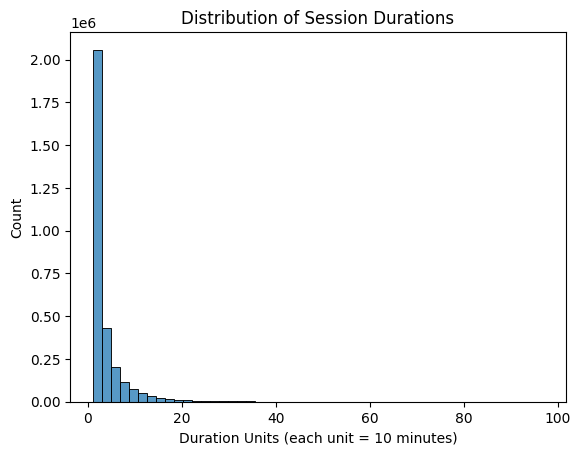

In [9]:
sns.histplot(df['duration'], bins=50)
plt.title("Distribution of Session Durations")
plt.xlabel("Duration Units (each unit = 10 minutes)")
plt.ylabel("Count")
plt.show()

## Top Streamers and Active Users

Which streamers appear most frequently and which users generate the most interaction records.
This shows streamer popularity imbalance which can affect collaborative filtering and sequence models.


In [10]:
top_streamers = df['streamer_username'].value_counts().head(20)
top_users = df['user_id'].value_counts().head(20)

top_streamers, top_users

(streamer_username
 ninja             45144
 tfue              40136
 shroud            27362
 riotgames         17633
 sodapoppin        14590
 nickmercs         14047
 dakotaz           13902
 asmongold         13186
 summit1g          13039
 esl_csgo          12547
 timthetatman      12388
 xqcow             11977
 symfuhny          11737
 gotaga            11465
 solaryfortnite    11413
 fortnite           9684
 tsm_hamlinz        9476
 tfblade            9274
 lirik              8911
 loltyler1          8626
 Name: count, dtype: int64,
 user_id
 42161    327
 43043    319
 17309    309
 9308     305
 99304    304
 45796    298
 67131    295
 75466    292
 83683    291
 93772    290
 17601    287
 52169    281
 65949    277
 51818    276
 88872    273
 7735     269
 58337    268
 39593    263
 79005    263
 64507    262
 Name: count, dtype: int64)

## Top 20 Streamers by Interaction Count


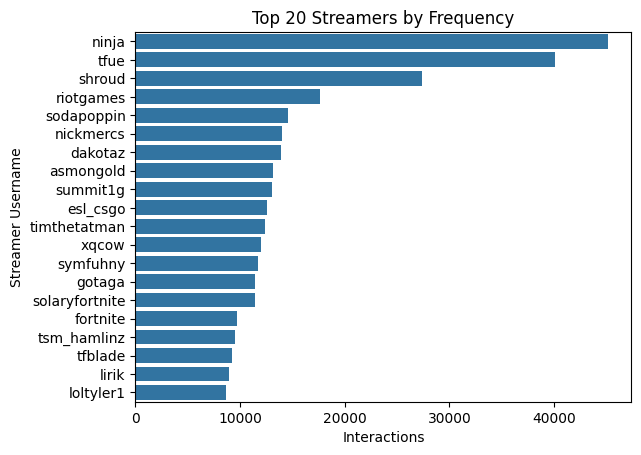

In [11]:
sns.barplot(x=top_streamers.values, y=top_streamers.index)
plt.title("Top 20 Streamers by Frequency")
plt.xlabel("Interactions")
plt.ylabel("Streamer Username")
plt.show()

## Time-Based Structure

Plotting the distribution of `time_start` to check activity patterns:
- Peak hours
- Unusual gaps
- Periodicity over 43 days


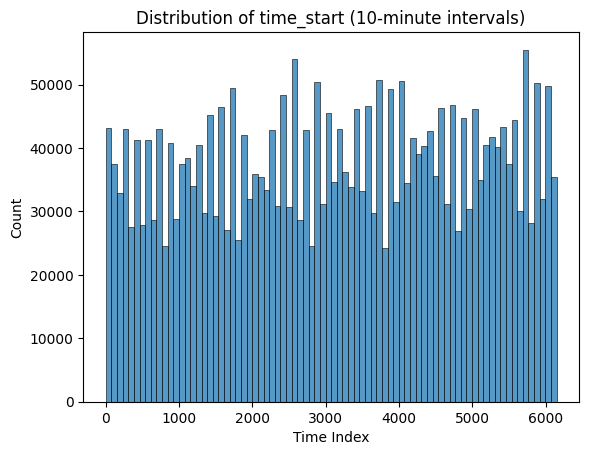

In [12]:
sns.histplot(df['time_start'], bins=80)
plt.title("Distribution of time_start (10-minute intervals)")
plt.xlabel("Time Index")
plt.ylabel("Count")
plt.show()

## Next Steps

This initial exploration familiarizes us with the structure and characteristics of the Twitch dataset.  
Going forward, we will:

1. Construct chronological user sequences for Task 1 (next-streamer prediction).
2. Build (user, streamer) return labels for Task 2.
3. Construct streamer co-viewership matrices for Task 3.

Subsequent sections will include:
- Train/validation/test construction
- Collaborative filtering feature extraction
- Markov transition estimation
- Similarity modeling and clustering

This establishes the foundation for the three recommender tasks in the full project.


# Exploring the Full Twitch Dataset (Large-Scale, 6GB+)

The full dataset (`full_a.csv.gz`) contains approximately 124 million user–stream interactions.
This file is too large to load into memory directly, so we analyze it using *chunked processing*.

Our goals in this section are to compute:

- total number of interactions  
- number of unique users  
- number of unique streamers  
- distribution of session durations  
- earliest and latest timestamps  
- approximate streamer popularity distribution  

We process the file in chunks of 1–5 million rows at a time to avoid memory issues.


In [13]:
full_path = "data/full_a.csv.gz"

# Schema based on documentation
colnames = ["user_id", "stream_id", "streamer_username", "time_start", "time_stop"]

# Adjust chunk size based on your RAM (1–5 million rows/chunk)
CHUNK_SIZE = 2_000_000  


In [14]:
import json
from collections import Counter

total_rows = 0
unique_users = set()
unique_streamers = set()
all_durations = []
min_time = float("inf")
max_time = float("-inf")

streamer_counter = Counter()


In [15]:
for chunk in pd.read_csv(full_path, 
                         header=None, 
                         names=colnames,
                         chunksize=CHUNK_SIZE,
                         compression='gzip'):

    # Update counts
    total_rows += len(chunk)

    # Unique users and streamers
    unique_users.update(chunk["user_id"].astype(str))
    unique_streamers.update(chunk["streamer_username"].astype(str))

    # Duration statistics
    duration = chunk["time_stop"] - chunk["time_start"]
    all_durations.extend(duration.tolist())

    # Time range
    min_time = min(min_time, chunk["time_start"].min())
    max_time = max(max_time, chunk["time_start"].max())

    # Streamer popularity
    streamer_counter.update(chunk["streamer_username"].astype(str))

    # Optional: print status updates
    print(f"Processed {total_rows:,} rows...", end="\r")

print("\nFinished processing full dataset.")


Processed 474,676,930 rows...
Finished processing full dataset.


# Summary Statistics for Full Dataset
Below we compute and display:
- number of interactions
- number of unique users
- number of unique streamers
- time coverage
- distribution of session durations
- top streamers by interaction volume

In [16]:
print(f"Total interactions: {total_rows:,}")
print(f"Unique users: {len(unique_users):,}")
print(f"Unique streamers: {len(unique_streamers):,}")
print(f"Time range: {min_time} → {max_time}")

dur_arr = np.array(all_durations)
print("Session duration stats:")
print(pd.Series(dur_arr).describe())

# Top 20 streamers overall
top20 = streamer_counter.most_common(20)
top20

Total interactions: 474,676,930
Unique users: 15,524,309
Unique streamers: 790,100
Time range: 0 → 6147
Session duration stats:
count    4.746769e+08
mean     3.153806e+00
std      4.270904e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      1.820000e+02
dtype: float64


[('ninja', 7084174),
 ('tfue', 6317942),
 ('shroud', 4240796),
 ('riotgames', 2792464),
 ('sodapoppin', 2319759),
 ('nickmercs', 2218550),
 ('dakotaz', 2151046),
 ('summit1g', 2076143),
 ('asmongold', 2052946),
 ('timthetatman', 1983744),
 ('esl_csgo', 1891247),
 ('xqcow', 1871984),
 ('symfuhny', 1809097),
 ('solaryfortnite', 1718210),
 ('gotaga', 1715941),
 ('fortnite', 1485680),
 ('tfblade', 1477826),
 ('tsm_hamlinz', 1475953),
 ('loltyler1', 1365728),
 ('lirik', 1356751)]